#1. The Data

In [ ]:
! git clone https://github.com/rianrajagede/object-detection.git

fatal: destination path 'tfod-supports' already exists and is not an empty directory.


In [ ]:
from PIL import Image
from PIL import ImageDraw

main_path = "/content/tfod-supports"

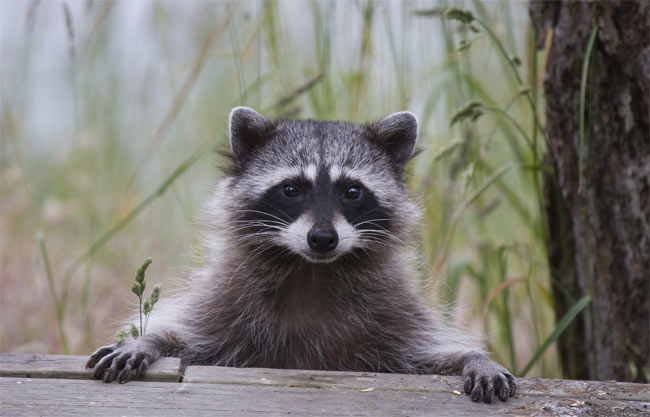

In [ ]:
image = Image.open(main_path + "/dataset_obj/racoon/raccoon-1.jpg")
image

## racoon-1.jpg Provided XML


```
<annotation verified="yes">
 <folder>images</folder>
 <filename>raccoon-1.jpg</filename>
 <path>/Users/datitran/Desktop/raccoon/images/raccoon-1.jpg</path>
 <source>
  <database>Unknown</database>
 </source>
 <size>
  <width>650</width>
  <height>417</height>
  <depth>3</depth>
 </size>
 <segmented>0</segmented>
 <object>
  <name>raccoon</name>
  <pose>Unspecified</pose>
  <truncated>0</truncated>
  <difficult>0</difficult>
  <bndbox>
   <xmin>81</xmin>
   <ymin>88</ymin>
   <xmax>522</xmax>
   <ymax>408</ymax>
  </bndbox>
 </object>
</annotation>
```

## Draw the box

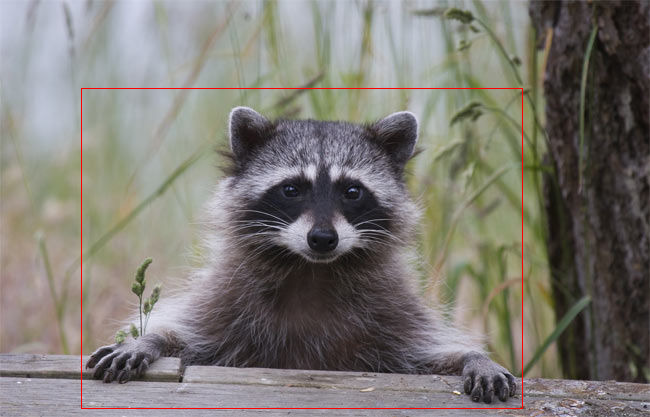

In [ ]:
xmin = 81
ymin = 88
xmax = 522
ymax = 408
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
image

# 2. Installation

In [ ]:
!pip install pyyaml==5.1 pycocotools==2.0.1

In [ ]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

1.5.1+cu101
0.6.1+cu101


In [ ]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


# 3. Import

In [ ]:
import torch, torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import pandas as pd
import cv2
import random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFile

import os

ImageFile.LOAD_TRUNCATED_IMAGES = True
main_path = "/content/tfod-supports"

# 4. Create Dataset

In [ ]:
labelmap = {
    "kangaroo" : 0,
    "raccoon" : 1
}

def get_dicts(settype):
    if settype=="test":
        csvpath = main_path+"/test_labels.csv"
    else:
        csvpath = main_path+"/train_labels.csv"

    df = pd.read_csv(csvpath).values

    dataset_dicts = []
    done = []
    for idx in range(len(df)):
        record = {}
        filename = df[idx, 0]
        record["image_id"] = idx
        record["file_name"] =  main_path + "/" + settype + "/" + filename
        record["width"] = df[idx, 1]
        record["height"] = df[idx, 2]

        if filename in done:
            continue
            
        done.append(filename)

        objs = []
        for row in df[df[:,0]==filename]:
            objs.append({
                    "bbox": [ row[4], row[5],
                              row[6], row[7]],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": labelmap[row[3]],
            })
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [ ]:
DatasetCatalog.clear()

In [ ]:
DatasetCatalog.register("racka_train", lambda t="train":get_dicts(t))
DatasetCatalog.register("racka_test", lambda t="test":get_dicts(t))

MetadataCatalog.get("racka_train").set(thing_classes=["kangaroo", "raccoon"])
MetadataCatalog.get("racka_test").set(thing_classes=["kangaroo", "raccoon"])

Metadata(name='racka_test', thing_classes=['kangaroo', 'raccoon'])

In [ ]:
DatasetCatalog.get("racka_train")

[{'annotations': [{'bbox': [156, 114, 240, 309],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0},
   {'bbox': [222, 117, 415, 306],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/tfod-supports/train/00002.jpg',
  'height': 309,
  'image_id': 0,
  'width': 550},
 {'annotations': [{'bbox': [99, 5, 403, 279],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/tfod-supports/train/00003.jpg',
  'height': 288,
  'image_id': 2,
  'width': 460},
 {'annotations': [{'bbox': [15, 71, 316, 233],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/tfod-supports/train/00004.jpg',
  'height': 319,
  'image_id': 3,
  'width': 450},
 {'annotations': [{'bbox': [508, 213, 843, 466],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': '/content/tfod-supports/train/00005.jpg',
  'height': 615,
  'image_id': 4,
  'width': 1000},
 {'annotations': [{'bbo

In [ ]:
try_dataset = DatasetCatalog.get("racka_train")
metadata = MetadataCatalog.get("racka_train")

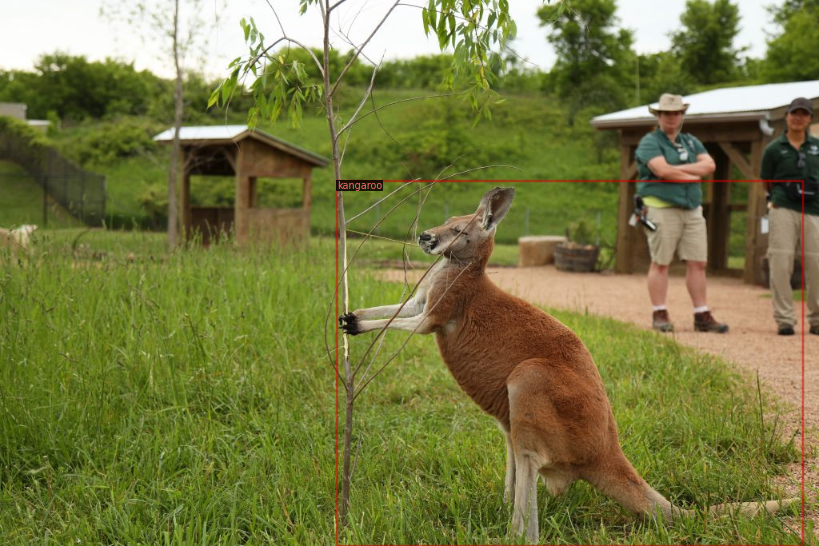

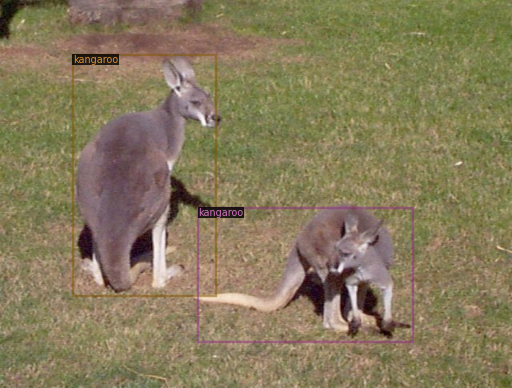

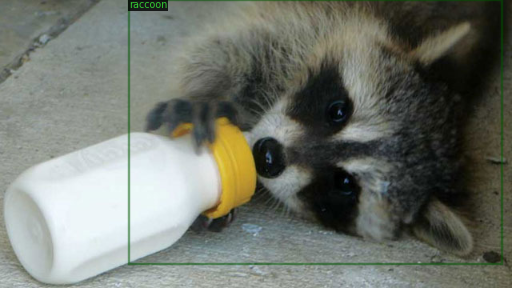

In [ ]:
for d in random.sample(try_dataset, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img, metadata=metadata, scale=0.8)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image())

# 5. Train

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("racka_train",)
cfg.DATASETS.TEST = ("racka_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.MAX_ITER = 250   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 48
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.TEST.EVAL_PERIOD = 50

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/08 10:35:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model!


[07/08 10:35:34 d2.engine.train_loop]: Starting training from iteration 0
[07/08 10:36:47 d2.utils.events]:  eta: 0:14:12  iter: 19  total_loss: 2.076  loss_cls: 1.107  loss_box_reg: 0.969  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  time: 3.6260  data_time: 0.0151  lr: 0.000020  max_mem: 7451M
[07/08 10:38:01 d2.utils.events]:  eta: 0:13:12  iter: 39  total_loss: 1.786  loss_cls: 0.846  loss_box_reg: 0.950  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 3.6517  data_time: 0.0075  lr: 0.000040  max_mem: 7451M
[07/08 10:38:38 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  kangaroo  | 2            |  raccoon   | 2            |
|            |              |            |              |
|   total    | 4            |            |              |
[07/08 10:38:38 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[07/08 10:3

In [ ]:
!mv "output/" "/content/drive/My Drive/racoon_new_dataset/new_output/"

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/racoon_new_dataset/new_output/output/", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("racka_test", )
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=1, image_height=495, image_width=450, fields=[pred_boxes: Boxes(tensor([[138.4281,   0.0000, 450.0000, 483.0032]], device='cuda:0')), scores: tensor([0.9849], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


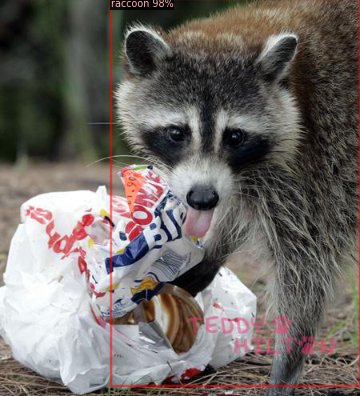

{'instances': Instances(num_instances=1, image_height=417, image_width=650, fields=[pred_boxes: Boxes(tensor([[ 94.9989,  84.0215, 527.8209, 409.0011]], device='cuda:0')), scores: tensor([0.9908], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


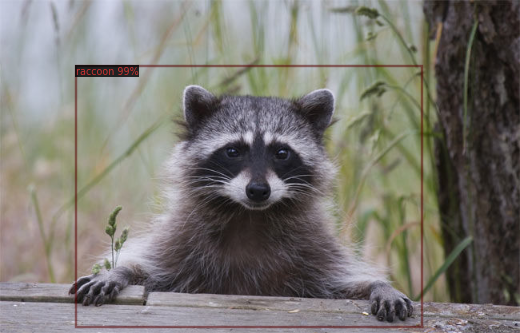

{'instances': Instances(num_instances=2, image_height=319, image_width=450, fields=[pred_boxes: Boxes(tensor([[123.2302,  96.0518, 309.0359, 259.7799],
        [227.5887,  84.9431, 373.1227, 263.7459]], device='cuda:0')), scores: tensor([0.9725, 0.9667], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}


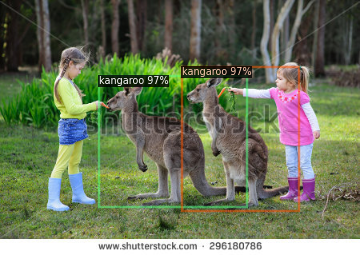

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dicts("test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.8, 
                #    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("racka_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "racka_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/08 11:06:24 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'racka_test'. Trying to convert it to COCO format ...
[07/08 11:06:24 d2.data.datasets.coco]: Converting annotations of dataset 'racka_test' to COCO format ...)
[07/08 11:06:24 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/08 11:06:24 d2.data.datasets.coco]: Conversion finished, #images: 3, #annotations: 4
[07/08 11:06:24 d2.data.datasets.coco]: Caching COCO format annotations at './output/racka_test_coco_format.json' ...
[07/08 11:06:24 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[07/08 11:06:24 d2.data.common]: Serialized dataset takes 0.00 MiB
[07/08 11:06:24 d2.evaluation.evaluator]: Start inference on 3 images
[07/08 11:06:26 d2.evaluation.evaluator]: Total inference time: 0:00:00.652099 (0.652099 s / img per device, on 1 devices)
[07/08 11:06:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00

OrderedDict([('bbox',
              {'AP': 73.78712871287128,
               'AP-kangaroo': 57.57425742574257,
               'AP-raccoon': 90.0,
               'AP50': 100.0,
               'AP75': 62.62376237623762,
               'APl': 73.78712871287128,
               'APm': nan,
               'APs': nan})])

# 6. Inference

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/racoon_new_dataset/new_output/output/", "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=2, image_height=327, image_width=432, fields=[pred_boxes: Boxes(tensor([[190.9720,  18.8939, 431.9248, 324.4408],
        [  0.0000,  29.0656, 218.5649, 294.9188]], device='cuda:0')), scores: tensor([0.9821, 0.9547], device='cuda:0'), pred_classes: tensor([1, 0], device='cuda:0')])}


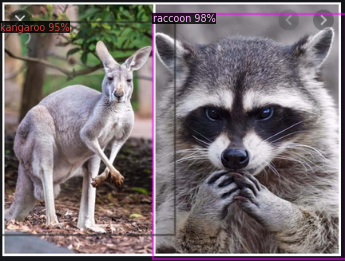

In [ ]:
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("/content/drive/My Drive/racoon_new_dataset/TestImage.png")
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])